In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sklearn as sk
import pandas
import numpy as np
import tensorflow as tf
import random
import os
import collections
import math
import time
import datetime
from tensorflow.contrib import learn
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.cross_validation import train_test_split
from matplotlib import pylab

# Allow print picture or graph in Ipython
%matplotlib inline
# Allow print all arry if command print called
np.set_printoptions(threshold=np.inf)                       

In [2]:
from load_data import load_file, separate_data_label, label_encoding

In [3]:
from text_cnn import TextCNN

In [4]:
import network_layer

In [5]:
# Load classified Document
document1 = load_file("2007ChallengeTrainData.xml")
id_doc1, labels, words1 = separate_data_label(document1)

In [6]:
# Load unclassified Document
# Load more words from these document to improve word-embedding
document2 = load_file("2007ChallengeTestDataNoCodes.xml")
id_doc2, labels2, words2 = separate_data_label(document2)            # labels2 is empty variable

In [7]:
id_doc = id_doc1 + id_doc2
words = words1 + words2

del labels2                                                          # delete empty variable to save memory

In [8]:
print(len(words1))

978


In [9]:
print(len(words))

1954


In [10]:
print(label_encoding(labels))

     079.99  277.00  279.12  462  486  493.90  511.9  518.0  591  592.0  \
0         0       0       0    0    0       0      0      0    0      0   
1         0       0       0    0    0       0      0      0    0      0   
2         0       0       0    0    0       0      0      0    0      0   
3         0       0       0    0    0       0      0      0    0      0   
4         0       0       0    0    0       0      0      0    0      0   
5         0       0       0    0    0       0      0      0    0      0   
6         0       0       0    0    0       0      0      0    0      0   
7         0       0       0    0    0       0      0      0    0      0   
8         0       0       0    0    0       0      0      0    0      0   
9         0       0       0    0    0       0      0      0    0      0   
10        0       0       0    0    0       0      0      0    0      0   
11        0       0       0    0    0       0      0      0    0      0   
12        0       0      

In [11]:
print(len(id_doc))

1954


In [12]:
print(len(words))

1954


In [13]:
words = [item for sublist in words for item in sublist] 

In [14]:
print(words)

[u'eleven', u'year', u'old', u'with', u'all', u',', u'bone', u'marrow', u'transplant', u'on', u'jan', u'2', u',', u'now', u'with', u'three', u'day', u'history', u'of', u'cough', u'1', u'no', u'focal', u'pneumonia', u'likely', u'chronic', u'changes', u'at', u'the', u'left', u'lung', u'base', u'2', u'mild', u'anterior', u'wedging', u'of', u'the', u'thoracic', u'vertebral', u'bodies', u'six', u'year', u'old', u'with', u'history', u'of', u'cough', u'for', u'one', u'week', u'the', u'lungs', u'are', u'clear', u'question', u'prominent', u'hilar', u'lymph', u'nodes', u',', u'left', u'greater', u'than', u'right', u',', u'which', u'could', u'be', u'reactive', u'in', u'nature', u'four', u'month', u'old', u'with', u'history', u'of', u'cough', u'no', u'radiographic', u'abnormality', u'seen', u'of', u'the', u'chest', u'sixteen', u'and', u'a', u'half', u'year', u'old', u'male', u'with', u'history', u'of', u'wrestling', u'injury', u'to', u'the', u'left', u'neck', u'and', u'shoulder', u'some', u'pleura

In [15]:
vocabulary_size = len(words)

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  #print(count)
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

# reverse_dictionary used number index to access
# dictionary used word keyword to access
data, count, dictionary, reverse_dictionary = build_dataset(words)

del words  # Hint to reduce memory.
#add this line to modify
vocabulary_size = len(dictionary)
print('Dictionary size', len(dictionary))

Dictionary size 2000


In [16]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

In [17]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [18]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):  
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 5.943624
Nearest to chest: every, spontaneous, laboratory, twenty, female, assuming, tachypnea, thereof,
Nearest to year: ten, accounts, calculus, pituitary, lumbar, replaced, little, 8year,
Nearest to or: v, beneficial, alternatively, 4, fat, reconstruction, merely, documenting,
Nearest to male: underlying, material, vaginal, site, daily, clips, workup, voids,
Nearest to sided: deformity, subsequently, crampy, change, 3rd, 5, phone, vomiting,
Nearest to 7: apparent, supported, duration, r9, particularly, symptomatology, curve, descending,
Nearest to kidney: particularly, peristalsis, clinical, followup, wall, got, slightly, urinary,
Nearest to small: asthmatic, 85, amenable, abrasions, based, infection, involves, hypertrophy,
Nearest to disease: atrophic, gagging, nephrectomy, partially, tonsils, pulmonologist, j, resolved,
Nearest to airways: supine, lumbar, whether, labored, aorta, positional, since, obstructions,
Nearest to bilateral: basketball,

In [21]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

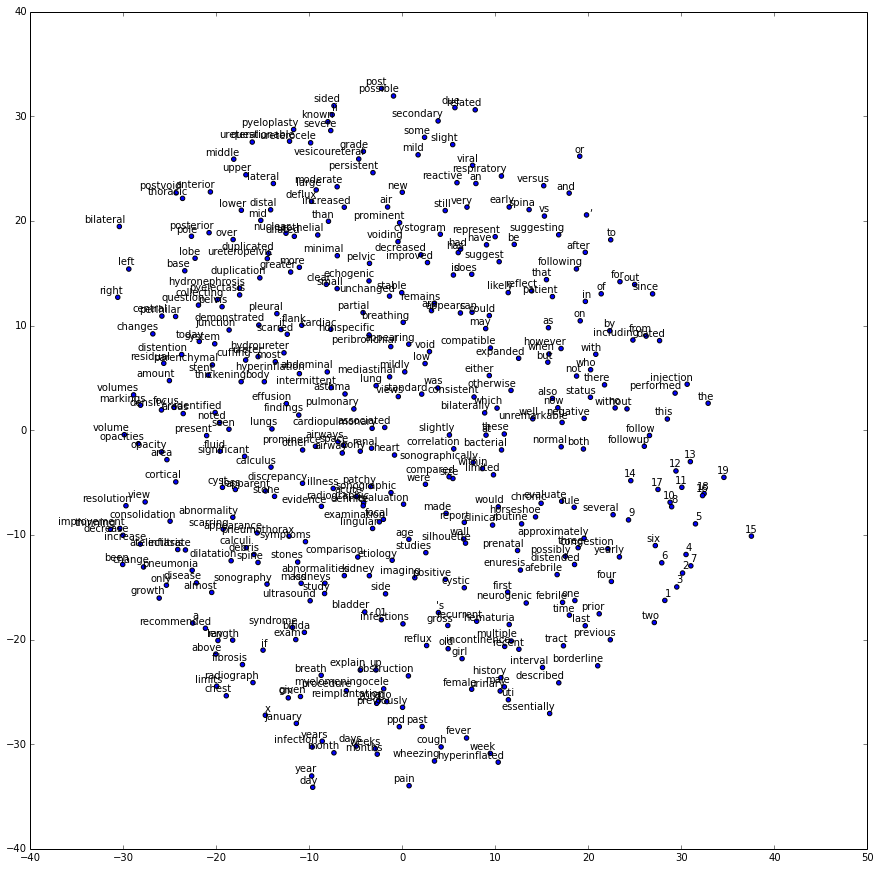

In [22]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

## Implement Word2vec To Neural Network

#### Neural Network Parameter

In [26]:
embedding_dim = 128
filter_sizes = [3, 4, 5]
num_filters = 128
dropout_keep_prob = 0.5
l2_reg_lambda = 0.0

In [27]:
batch_size = 64
num_epochs = 200
evaluate_every = 100
checkpoint_every = 100

#### Input preparation

In [59]:
# Create a 2D blank 2D array
# embedding size = 128
x = np.zeros((len(dictionary), embedding_size),dtype="float32")

In [60]:
# One-hot-encoding label of each document
# There are 978 documents and 45 labels
y = label_encoding(labels)                                      # Encode data Label in DataFrame type
y = y.as_matrix()                                      # Convert DataFrame type to numpy array                                                                       # For other calculation

In [69]:
for indexDoc in words1:
#    for indexWord in indexDoc:
#        print("%s %s" % (indexDoc, indexWord))
    print(indexDoc)

[u'eleven', u'year', u'old', u'with', u'all', u',', u'bone', u'marrow', u'transplant', u'on', u'jan', u'2', u',', u'now', u'with', u'three', u'day', u'history', u'of', u'cough', u'1', u'no', u'focal', u'pneumonia', u'likely', u'chronic', u'changes', u'at', u'the', u'left', u'lung', u'base', u'2', u'mild', u'anterior', u'wedging', u'of', u'the', u'thoracic', u'vertebral', u'bodies']
[u'six', u'year', u'old', u'with', u'history', u'of', u'cough', u'for', u'one', u'week', u'the', u'lungs', u'are', u'clear', u'question', u'prominent', u'hilar', u'lymph', u'nodes', u',', u'left', u'greater', u'than', u'right', u',', u'which', u'could', u'be', u'reactive', u'in', u'nature']
[u'four', u'month', u'old', u'with', u'history', u'of', u'cough', u'no', u'radiographic', u'abnormality', u'seen', u'of', u'the', u'chest']
[u'sixteen', u'and', u'a', u'half', u'year', u'old', u'male', u'with', u'history', u'of', u'wrestling', u'injury', u'to', u'the', u'left', u'neck', u'and', u'shoulder', u'some', u'ple

In [64]:
for indexDoc in words1:
    for indexWord in indexDoc:
        if indexWord in dictionary.values():                    # Check If the words have in dictionary
            vectLocate = dictionary[indexWord]                  # All rare words is treated as UNK Token
            #x[indexDoc][vectLocate] = final_embeddings[vectLocate]
            x[vectLocate] = final_embeddings[vectLocate]
            print(x[indexDoc][vectLocate])
        else:                                                   # If the word is not in dictionary
            vectLocate = dictionary['UNK']                      # It may be a rare word
            #x[indexDoc][vectLocate] = final_embeddings[vectLocate]
            x[vectLocate] = final_embeddings[vectLocate]

In [38]:
# Randomly shuffle data
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

In [39]:
# Split train/test set
# TODO: This is very crude, should use cross-validation
# split data into training (80%) and test (20%)
x_train, x_dev = train_test_split(x_shuffled, train_size = 0.8)
y_train, y_dev = train_test_split(y_shuffled, train_size = 0.8)

In [40]:
print(len(x_train), len(x_dev))
print(len(y_train), len(y_dev))

782 196
782 196


In [41]:
# Sort each data and label into one pair
# then shuffle to ensure randomness 
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int(len(data)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [42]:
batches = batch_iter(
        list(zip(x_train, y_train)), batch_size, num_epochs)

#### Training

In [98]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=True,
      log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        cnn = TextCNN(
            sequence_length=x_train.shape[1],
            num_classes=45,
            vocab_size=len(dictionary),
            embedding_size=embedding_dim,
            filter_sizes=filter_sizes,
            num_filters=num_filters,
            l2_reg_lambda=l2_reg_lambda)

        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Keep track of gradient values and sparsity (optional)
        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.histogram_summary("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.scalar_summary("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.merge_summary(grad_summaries)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        loss_summary = tf.scalar_summary("loss", cnn.loss)
        acc_summary = tf.scalar_summary("accuracy", cnn.accuracy)

        # Train Summaries
        train_summary_op = tf.merge_summary([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.train.SummaryWriter(train_summary_dir, sess.graph)

        # Dev summaries
        dev_summary_op = tf.merge_summary([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.train.SummaryWriter(dev_summary_dir, sess.graph)

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.all_variables())

        # Store vocabulary embedded
        #dictionary.save(os.path.join(out_dir, "vocab"))

        # Initialize all variables
        sess.run(tf.initialize_all_variables())


Writing to /home/ubuntu/workspace/tensorflow/thesis/Real/runs/1472183662



In [99]:
def train_step(x_batch, y_batch):
    """
    A single training step
    """
    feed_dict = {
        cnn.input_x: x_batch,
        cnn.input_y: y_batch,
        cnn.dropout_keep_prob: dropout_keep_prob
    }
    _, step, summaries, loss, accuracy = sess.run(
        [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
        feed_dict)
    time_str = datetime.datetime.now().isoformat()
    print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
    train_summary_writer.add_summary(summaries, step)

In [100]:
def dev_step(x_batch, y_batch, writer=None):
    """
    Evaluates model on a dev set
    """
    feed_dict = {
        cnn.input_x: x_batch,
        cnn.input_y: y_batch,
        cnn.dropout_keep_prob: 1.0
    }
    step, summaries, loss, accuracy = sess.run(
        [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
        feed_dict)
    time_str = datetime.datetime.now().isoformat()
    print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
    if writer:
        writer.add_summary(summaries, step)

In [101]:
for batch in batches:
    x_batch, y_batch = zip(*batch)
    train_step(x_batch, y_batch)
    current_step = tf.train.global_step(sess, global_step)
    if current_step % evaluate_every == 0:
        print("\nEvaluation:")
        dev_step(x_dev, y_dev, writer=dev_summary_writer)
        print("")
        if current_step % checkpoint_every == 0:
            path = saver.save(sess, checkpoint_prefix, global_step=current_step)
            print("Saved model checkpoint to {}\n".format(path))

2016-08-26T03:54:29.849855: step 1, loss 5.22048, acc 0
2016-08-26T03:54:30.870569: step 2, loss 5.20436, acc 0.125
2016-08-26T03:54:31.952485: step 3, loss 5.12945, acc 0.109375
2016-08-26T03:54:33.434674: step 4, loss 4.24819, acc 0.21875
2016-08-26T03:54:34.444123: step 5, loss 4.63165, acc 0.078125
2016-08-26T03:54:35.377403: step 6, loss 4.04226, acc 0.078125
2016-08-26T03:54:36.382592: step 7, loss 4.57526, acc 0.109375
2016-08-26T03:54:37.355267: step 8, loss 4.10704, acc 0.140625
2016-08-26T03:54:38.311304: step 9, loss 3.95963, acc 0.15625
2016-08-26T03:54:39.255067: step 10, loss 3.96404, acc 0.15625
2016-08-26T03:54:40.248489: step 11, loss 3.99243, acc 0.078125
2016-08-26T03:54:41.233366: step 12, loss 4.27692, acc 0.109375
2016-08-26T03:54:41.446633: step 13, loss 4.33692, acc 0.0714286
2016-08-26T03:54:42.420285: step 14, loss 3.70812, acc 0.25
2016-08-26T03:54:43.404975: step 15, loss 4.02436, acc 0.09375
2016-08-26T03:54:44.379245: step 16, loss 4.61735, acc 0.09375
201

## Try code

In [57]:
from sklearn.cross_validation import KFold
kf = KFold(len(y), n_folds=10, shuffle=True)
print(len(y))

978


In [70]:
for train, test in kf:
    x[train, :]
    y[train]
    #print("%s" % test)
    print(len(test))

98
98
98
98
98
98
98
98
97
97


In [79]:
x = np.zeros((len(words1),len(dictionary)*embedding_size),dtype="float32")

In [74]:
print

In [41]:
embedding_dim = 128
filter_sizes = [3, 4, 5]
num_filters = 128
dropout_keep_prob = 0.5
l2_reg_lambda = 0.0

In [45]:
MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
FILTER_SHAPE1 = [20, 2012]
FILTER_SHAPE2 = [20, N_FILTERS]
POOLING_WINDOW = 4
POOLING_STRIDE = 2

In [43]:
input_conv = tf.reshape(final_embeddings, [1, final_embeddings.shape[0], final_embeddings.shape[1], 1])
W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")

In [ ]:
pooled_outputs = []
for i, filter_size in enumerate(filter_sizes):
    with tf.name_scope("conv-maxpool-%s" % filter_size):
        # Convolution Layer
        filter_shape = [filter_size, embedding_size, 1, num_filters]
        W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
        conv1 = tf.contrib.layers.convolution2d(input_conv, N_FILTERS,
                                            FILTER_SHAPE1, padding='VALID')

""""" ######################################################################## """"""

In [51]:
# Weights
W = tf.Variable(tf.truncated_normal([2012, 128], mean=0.0, stddev=1.0,
                                    dtype=tf.float32, seed=None, name="weight"))

In [ ]:
# Input
x = tf.placeholder(tf.float32, name="x", shape[257536, 128])

In [55]:
x = tf.placeholder(tf.float32, name="x", shape=[None, 257536])
W = tf.Variable(tf.random_uniform([257536, 45], -1, 1), name="W")
b = tf.Variable(tf.zeros([45]), name="biases")
output = tf.matmul(x, W) + b

init_op = tf.initialize_all_variables()

sess = tf.Session() 
sess.run(init_op)

In [61]:
x = tf.reshape(x, shape=[-1, 2012, 128, 1])

In [62]:
feed_dict = {x : final_embeddings}
sess.run(output, feed_dict= feed_dict)

ValueError: Cannot feed value of shape (2012, 128) for Tensor u'Reshape_4:0', which has shape '(1, 2012, 128, 1)'